**Содержание**<a id='toc0_'></a>    
- [Сборный проект 2](#toc1_)    
  - [Описание проекта](#toc1_1_)    
  - [Описание данных](#toc1_2_)    
  - [Загрузка и подготовка данных](#toc1_3_)    
    - [Изучение и проверка данных](#toc1_3_1_)    
    - [Выводы](#toc1_3_2_)    
  - [Изучаем воронку событий](#toc1_4_)    
    - [Выводы](#toc1_4_1_)    
  - [Изучаем результаты эксперимента](#toc1_5_)    
    - [Вывод](#toc1_5_1_)    
  - [Общие выводы по проекту](#toc1_6_)    

# <a id='toc1_'></a>[Сборный проект 2](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта](#toc0_)
Для анализа предоставлены данные о работе сервиса продажи продуктов питания. Нужно разобраться, как ведут себя пользователи мобильного приложения и как шрифт влияет на активность пользователей. \
Для этого изучим воронку продаж: узнаем, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.\
В исследовании используем А/А/В-эксперимент. Для него пользователей разделили на 3 группы: две контрольные со старыми шрифтами и одна экспериментальная — с новыми. Выясним, какой шрифт лучше.

## <a id='toc1_2_'></a>[Описание данных](#toc0_)
Каждая запись в логе — это действие пользователя, или событие. \
`EventName` — название события;\
`DeviceIDHash` — уникальный идентификатор пользователя;\
`EventTimestamp` — время события;\
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## <a id='toc1_3_'></a>[Загрузка и подготовка данных](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
print(data.head(10))
print(data.info())

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
5         CartScreenAppear  6217807653094995999      1564055323    248
6       OffersScreenAppear  8351860793733343758      1564066242    246
7         MainScreenAppear  5682100281902512875      1564085677    246
8         MainScreenAppear  1850981295691852772      1564086702    247
9         MainScreenAppear  5407636962369102641      1564112112    246
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName     

Явных пропусков в данных нет.\
Приведем названия столбцов к нижнему регистру, со столбцом с данными о дате и времени поработаем далее.

In [3]:
data.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
data.head(1)

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246


In [4]:
print('Количество дубликатов:', data.duplicated().sum())
data.drop_duplicates().reset_index(drop=True)

Количество дубликатов: 413


,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247
243709,MainScreenAppear,5849806612437486590,1565212439,246
243710,MainScreenAppear,5746969938801999050,1565212483,246
243711,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')
print(data.head(10))
print(data.info())

                event_name              user_id  event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257       1564029816     246   
1         MainScreenAppear  7416695313311560658       1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248   
3         CartScreenAppear  3518123091307005509       1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248   
5         CartScreenAppear  6217807653094995999       1564055323     248   
6       OffersScreenAppear  8351860793733343758       1564066242     246   
7         MainScreenAppear  5682100281902512875       1564085677     246   
8         MainScreenAppear  1850981295691852772       1564086702     247   
9         MainScreenAppear  5407636962369102641       1564112112     246   

            date_time       date  
0 2019-07-25 04:43:36 2019-07-25  
1 2019-07-25 11:11:42 2019-07-25  
2 2019-07-25 11:28:47 2019-07-25  
3 2019-07-25 11:28:47 2

### <a id='toc1_3_1_'></a>[Изучение и проверка данных](#toc0_)

In [6]:
print('В логе %d событий, типов событий %d.' % (data.shape[0], data['event_name'].nunique()))
print(data['event_name'].value_counts())

В логе 244126 событий, типов событий 5.
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64


In [7]:
print('%d пользователей.' % (data['user_id'].nunique()))

7551 пользователей.


In [8]:
print('В среднем %d события на пользователя.' % (data.shape[0] / data['user_id'].nunique()))

В среднем 32 события на пользователя.


In [9]:
first_date = data['date_time'].min().date()
last_date = data['date_time'].max().date()
print('Эксперимент проводился с %s по %s.' % (first_date, last_date))

Эксперимент проводился с 2019-07-25 по 2019-08-07.


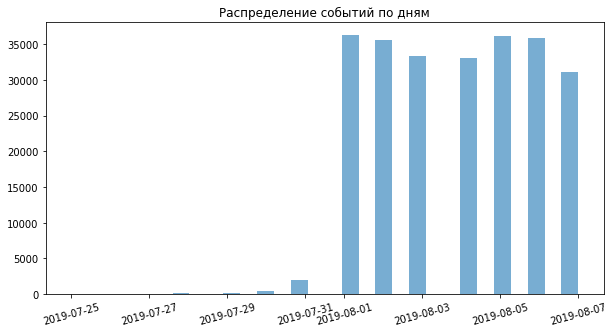

In [10]:
plt.title('Распределение событий по дням')
data['date'].hist(bins=30, xrot=15,  figsize=(10, 5), alpha=0.6, grid=False)
plt.show()

Мы выяснили, что в предоставленных данных диапазон дат с 25 июля по 7 августа, однако наиболее насыщен событиями период с 1 по 7 августа. Для дальнейшего анализа будем использовать этот уточненный временной интервал.

In [11]:
clean_data=data.drop(data[data['date'] < '2019-08-01'].index)
print('Отбросили:')
print(data['event_name'].value_counts().sum() - clean_data['event_name'].value_counts().sum(), 'событий ~', \
      round((1 - clean_data['event_name'].value_counts().sum() / data['event_name'].value_counts().sum()) * 100, 2), '%')
print(data['user_id'].nunique() - clean_data['user_id'].nunique(), 'пользователей ~', \
      round((1 - clean_data['user_id'].nunique() / data['user_id'].nunique()) * 100, 2), '%')

Отбросили:
2828 событий ~ 1.16 %
17 пользователей ~ 0.23 %


In [12]:
clean_data.groupby('exp_id').agg({'user_id': ['count', 'nunique']})

user_id        
         count nunique
exp_id                
246      79425    2484
247      77147    2513
248      84726    2537

После сокращения временного интервала для анализа мы потеряли допустимое количество данных. Экспериментальные группы сохранны, во всех трех содержится оптимальное количество пользователей для проведения анализа.

### <a id='toc1_3_2_'></a>[Выводы](#toc0_)
Ознакомились с предоставленными данными и провели предобработку: привели названия колонок к нижнему регистру, избавились от дублированных строк, уточнили временной диапазон для анализа данных А/А/В-эксперимента и убедились, что данных достаточно для анализа.

## <a id='toc1_4_'></a>[Изучаем воронку событий](#toc0_)

In [13]:
display(clean_data.groupby('event_name')['user_id'].count().sort_values(ascending = False))

event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: user_id, dtype: int64

В предоставленных данных всего пять типов событий:
* MainScreenAppear — главный экран,
* OffersScreenAppear — экран предложения,
* CartScreenAppear — корзина,
* PaymentScreenSuccessful — страница успешной оплаты,
* Tutorial — руководство.

In [14]:
event_users = clean_data.pivot_table(index=['event_name'], values='user_id', aggfunc={'nunique','count'}).reset_index() #создаем сводную таблицу: события и пользователи
event_users.columns = ['event', 'events_count', 'users_unique'] 
event_users['users_per'] = round(event_users['users_unique'] / clean_data['user_id'].nunique() * 100, 2) 
event_users = event_users.sort_values(by = 'users_per', ascending = False).reset_index() 
event_users

,index,event,events_count,users_unique,users_per
0,1,MainScreenAppear,117431,7419,98.47
1,2,OffersScreenAppear,46350,4593,60.96
2,0,CartScreenAppear,42365,3734,49.56
3,3,PaymentScreenSuccessful,34113,3539,46.97
4,4,Tutorial,1039,840,11.15


Видим, как складывается цепочка действий: пользователи обращаются к главной странице, переходят на страницу предложения, затем в корзину и оплачивают заказ.\
К руководству обращается всего 11% пользователей; очевидно, процесс покупки для большинства пользователей понятен и без руководства. Можем исключить это событие из воронки.

In [15]:
event_users = event_users[event_users['event'] != 'Tutorial']

In [16]:
event_users['conv_per'] = round((event_users['users_per'] / event_users['users_per'].shift(1,fill_value = event_users['users_per'].max())) * 100, 2)
event_users

,index,event,events_count,users_unique,users_per,conv_per
0,1,MainScreenAppear,117431,7419,98.47,100.00
1,2,OffersScreenAppear,46350,4593,60.96,61.91
2,0,CartScreenAppear,42365,3734,49.56,81.30
3,3,PaymentScreenSuccessful,34113,3539,46.97,94.77


В столбце `conv_per` — конверсия в шаг.\
На главном экране были все пользователи. Из них почти 62% перешли на страницу предложения. Из перешедших 81% перешли в корзину. Из тех, кто перешел в корзину, почти 95% совершили оплату.

In [17]:
fig = go.Figure(go.Funnel(y = event_users['event'],
                          x = event_users['users_unique'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий', autosize=False, width=800, height=600)
fig.show()

In [18]:
event_users['loss'] = (event_users['conv_per'] - event_users['conv_per'].shift(1))
event_users

,index,event,events_count,users_unique,users_per,conv_per,loss
0,1,MainScreenAppear,117431,7419,98.47,100.00,NaN
1,2,OffersScreenAppear,46350,4593,60.96,61.91,-38.09
2,0,CartScreenAppear,42365,3734,49.56,81.30,19.39
3,3,PaymentScreenSuccessful,34113,3539,46.97,94.77,13.47


В столбце `loss` — потеря между шагами.\
Больше всего пользователей (38%) теряем на этапе появления предложения. 

In [19]:
print('От первого события до оплаты доходит', \
      round(event_users[event_users['event'] == 'PaymentScreenSuccessful']['users_unique'][3] / \
            event_users[event_users['event'] == 'MainScreenAppear']['users_unique'][0] * 100, 2),'%')

От первого события до оплаты доходит 47.7 %


### <a id='toc1_4_1_'></a>[Выводы](#toc0_)
Построили и визуализировали воронку событий, изучили движение пользователей по воронке. Оказалось, что всего 11% пользователей заглядывают в руководство — поэтому это событие исключили из воронки.\
Больше всего пользователей теряем на этапе появления предложения — 38%.\
От первого события до оплаты доходит почти 48% пользователей.

## <a id='toc1_5_'></a>[Изучаем результаты эксперимента](#toc0_)

Перед тем как начать A/B-тест, убедимся, что:
* на результаты не влияют аномалии и выбросы в генеральной совокупности;
* инструмент «деления» трафика работает безошибочно;
* данные отправляются в системы аналитики корректно.
Для этого проведем A/A-тест.

Критерии успешного A/A-теста: 
* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [20]:
users_by_groups = clean_data.pivot_table(index=['exp_id'], values='user_id', aggfunc={'nunique'}).reset_index()
users_by_groups.columns = ['group_id', 'unique_users_amount']
print(users_by_groups)

uniq_user_group = clean_data.groupby('user_id').agg({'exp_id':'nunique'})
print('Пользователей, входящих более чем в одну группу теста:',\
      uniq_user_group[uniq_user_group['exp_id'] > 1]['exp_id'].count())

   group_id  unique_users_amount
0       246                 2484
1       247                 2513
2       248                 2537
Пользователей, входящих более чем в одну группу теста: 0


In [21]:
# посчитаем число пользователей, совершивших событие в каждой из контрольных групп
events_groups = clean_data.pivot_table(index=['event_name'], values='user_id', columns='exp_id', aggfunc={'nunique'}).reset_index()
# переименуем столбцы
events_groups.columns = ['event_name', '246', '247', '248']
events_groups = events_groups.sort_values(by='248', ascending=False).reset_index()
events_groups = events_groups[events_groups['event_name'] != 'Tutorial']
events_groups

,index,event_name,246,247,248
0,1,MainScreenAppear,2450,2476,2493
1,2,OffersScreenAppear,1542,1520,1531
2,0,CartScreenAppear,1266,1238,1230
3,3,PaymentScreenSuccessful,1200,1158,1181


Проведем А/А-тест: сравним две контрольные группы между собой по событиям. Для этого используем z-критерий Фишера так как сравниваем две независимые выборки большого размера. Критический уровень статистической значимости примем равным 5%.\
Будем сравнивать группы по каждому событию: всего у нас четыре события. Чтобы не допустить ошибку первого рода при множественном сравнении и не отвергнуть нулевую гипотезу, используем поправку Бонферрони.

In [22]:
#Функция принимает на вход данные о двух группах и событии, по которому сравниваем группы,
#критический уровень статистической значимости, поправку Бонферрони для крит. уровня стат. значимости.

def z_test(group1, group2, event, alpha, n):
  bonferroni_alpha = alpha / n # критический уровень статистической значимости c поправкой Бонферрони
  
  n_users = np.array([group1['user_id'].nunique(), 
                        group2['user_id'].nunique()]) # количество пользователей в группах
  
  success = np.array([group1[group1['event_name'] == event]['user_id'].nunique(), 
                        group2[group2['event_name'] == event]['user_id'].nunique()]) # количество пользователей, совершивших действие
    
  p1 = success[0]/n_users[0]
  p2 = success[1]/n_users[1] # пропорции успехов в группах
    
  p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

  difference = p1 - p2

  z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

  distr = st.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)  

  p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
  print('Событие:', event)
  print('p-значение: ', round(p_value, 3))

  if p_value < bonferroni_alpha:
      print('Отвергаем нулевую гипотезу: есть статистически значимое различие между группами')
  else:
      print('Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами') 

Сравним 246 и 247 группы между собой по четырем событиям.\
Гипотезы:\
H0: статистической значимости между группами нет.\
H1: есть статистическая значимость между группами.

В А/А тесте мы ожидаем увидеть полное отсутствие различий: пользователи обеих контрольных групп видели приложение с одним и тем же шрифтом.\
Так как всего нам предстоит 16 проверок гипотез (А/А, А/В с двумя контрольными и А/А/В по четырем событиям), в качестве поправки Бонферрони используем 16.

In [23]:
for event in events_groups['event_name'].unique():
    z_test(clean_data[clean_data['exp_id'] == 246], clean_data[clean_data['exp_id'] == 247], event,.05, 16)
    print()

Событие:

 MainScreenAppear
p-значение:  0.757
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: OffersScreenAppear
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: CartScreenAppear
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: PaymentScreenSuccessful
p-значение:  0.115
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами



В результате А/А-теста видим, что по всем четырем событиям контрольные группы 246 и 247 не имеют статистически значимых различий. Можем проводить А/В-тест.

В А/В-тесте будем сравнивать попарно каждую контрольную группу с тестовой группой, а также объединенную контрольную группу с тестовой; всего 12 сравнений. Поправка Бонферрони остается прежняя: 16.

In [24]:
for event in events_groups['event_name'].unique():
    z_test(clean_data[clean_data['exp_id'] == 246], clean_data[clean_data['exp_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: OffersScreenAppear
p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: CartScreenAppear
p-значение:  0.078
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: PaymentScreenSuccessful
p-значение:  0.212
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами



При заданном уровне значимости контрольная группа 246 и тестовая группа 248 не имеют статистически значимых различий при сравнении по событиям.

In [25]:
for event in events_groups['event_name'].unique():
    z_test(clean_data[clean_data['exp_id'] == 247], clean_data[clean_data['exp_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.459
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: OffersScreenAppear
p-значение:  0.92
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: CartScreenAppear
p-значение:  0.579
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: PaymentScreenSuccessful
p-значение:  0.737
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами



При заданном уровне значимости контрольная группа 247 и тестовая группа 248 не имеют статистически значимых различий при сравнении по событиям.

In [26]:
for event in events_groups['event_name'].unique():
    z_test(clean_data[clean_data['exp_id'] != 248], clean_data[clean_data['exp_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.294
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: OffersScreenAppear
p-значение:  0.434
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: CartScreenAppear
p-значение:  0.182
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами

Событие: PaymentScreenSuccessful
p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу: нет статистически значимого различия между группами



При заданном уровне значимости объединенная контрольная и тестовая группа 248 не имеют статистически значимых различий при сравнении по событиям.

### <a id='toc1_5_1_'></a>[Вывод](#toc0_)
По результатам А/А/В-теста, проведенного в период с 1 по 7 августа, статистически значимых различий в действиях пользователей из двух контрольных и одной тестовой группы нет, изменение шрифта не повлияло на поведение пользователей.

## <a id='toc1_6_'></a>[Общие выводы по проекту](#toc0_)
Мы изучили данные о работе приложения сервиса продажи продуктов питания. Нас интересовало, влияет ли смена шрифта в приложении на поведение пользователей.
* Для анализа были выведены три группы пользователей: две контрольные и одна экспериментальная, всего 7551 пользователь.
* Временной интервал для анализа: одна неделя, с 1 по 7 августа 2019 года.
* Событийная воронка выглядит так: пользователи обращаются к главной странице, переходят на страницу предложения, затем в корзину и оплачивают заказ. Мы исключили событие Tutorial (Руководство) из воронки, так как оно происходило всего у 11% пользователей.
* Больше всего пользователей — 38% — теряем на этапе появления на экране предложения.
* От первого события до оплаты доходит 47,7% пользователей.
* Провели А/А-тест: сравнили между собой контрольные группы по событиям, тем самым убедились в достоверности предоставленных данных.
* Провели А/А/В-тест с применением z-критерия Фишера для двух независимых выборок большого размера. Также применили поправку Бонферрони чтобы не допустить ошибку первого рода при множественных сравнениях.
* Всего провели 16 статистических проверок между двумя контрольными и одной экспериментальной группой для того, чтобы выявить статистически значимое различие в поведении пользователей.

**По результатам А/А/В-теста, проведенного в период с 1 по 7 августа, статистически значимых различий в действиях пользователей из двух контрольных и одной тестовой группы нет, изменение шрифта не повлияло на поведение пользователей.**


